In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import feather

ImportError: No module named 'fastai'

In [3]:
PATH = "C:/input/Fast_AI/week01/"
#df_raw = pd.read_feather("C:/input/Fast_AI/week01/tmp/bulldozers-raw", nthreads=1)
df_raw = feather.read_dataframe("C:/input/Fast_AI/week01/tmp/bulldozers-raw")


In [4]:
print(df_raw.shape)
df_raw.columns

(401125, 65)


Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [5]:
df_trn,y_trn,nas = proc_df(df_raw,'SalePrice')

In [6]:
df_trn.shape, y_trn.shape, type(nas), len(nas), print(nas)

{'MachineHoursCurrentMeter': 0.0, 'auctioneerID': 2.0}


((401125, 66), (401125,), dict, 2, None)

In [7]:
df_trn.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleI

In [8]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [9]:
x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]
x_sub.shape

(389125, 2)

In [10]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x, self.y, self.sample_sz, self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]
    
    def create_tree(self):
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz] # 随机抽取数据
        return DecisionTree(self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)
    
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [11]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        self.x, self.y, self.idxs, self.min_leaf = x,y,idxs,min_leaf

In [12]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [13]:
m.trees[0]

In [14]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
    
    def find_varsplit(self): #对每个column找到最佳分割点
        for i in range(self.c): self.find_better_split(i)
    
    def find_better_split(self, var_idx):pass
    
    @property
    def split_name(self): return self.x.columns[self.var_idx] #栏位名
    
    @property
    def split_col(self): return self.x.values[self.idxs, self.var_idx] #某个值
    
    @property
    def is_leaf(self): return self.score == float("inf")
    
    def __repr__(self): # 打印类的时候，控制类输出的字符串
        #s = f'n: {self.n}; val: {self.val}'
        s = 'n: %s; val: %s' %(self.n,self.val)
        if not self.is_leaf:
            #s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
            s += '; score:%s; split:%s; var:%s' %(self.score, self.split, self.split_name)
        return s
    

In [15]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [16]:
m.trees[0]

n: 1000; val: 10.079014121552744

In [17]:
#m.trees[0].idxs

In [18]:
ens = TreeEnsemble(x_sub, y_train, 1, 1000) # x_sub 只有两个栏位的子集测试局册数
tree = ens.trees[0]
x_samp, y_samp = tree.x, tree.y
print(tree.x.shape, tree.y.shape)
x_samp.columns

(1000, 2) (1000,)


Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

In [19]:
m = RandomForestRegressor(n_estimators=1, max_depth=1, bootstrap=False)
m.fit(x_samp,y_samp)
#draw_tree(m.estimators_[0], x_samp, precision=2) # make sure the Graphviz executables are on your systems' PATH


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=1,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [20]:
def find_better_split(self, var_idx): # 输入var_idx栏位
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs] # idxs行索引，idx某个列名
    
    for i in range(self.n): # n行数
        lhs = x<=x[i] # True or False
        rhs = x>x[i]
        if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf: continue
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        curr_score = lhs_std* lhs.sum() + lhs_std*rhs.sum()
        if curr_score < self.score:
            self.var_idx,self.score,self.split = var_idx,curr_score,x[i]

In [21]:
%timeit find_better_split(tree,1)
#DecisionTree.find_better_split = find_better_split # 效果相同
tree


10 loops, best of 3: 127 ms per loop


n: 1000; val: 10.079014121552744; score:677.7201639535342; split:1081.0; var:MachineHoursCurrentMeter

In [24]:
find_better_split(tree,0);tree

n: 1000; val: 10.079014121552744; score:512.1840749198973; split:1974.0; var:YearMade

性能优化

In [25]:
tree = TreeEnsemble(x_sub,y_train,1,1000).trees[0]

In [38]:
import math
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2) # 平方和的平均 - 平均数的平方

def find_better_split(self, var_idx):
    x,y = self.x.values[self.idxs, var_idx], self.y[self.idxs]
    
    sort_idx = np.argsort(x) # [10,1,5] -> [1,2,0]如果排序的话每个位置应该是第几个元素
    sort_y, sort_x = y[sort_idx], x[sort_idx] # 按照x有序排列
    rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum() #初始化
    lhs_cnt, lhs_sum, lhs_sum2 = 0,0.,0.
    
    for i in range(0, self.n-self.min_leaf):
        xi,yi = sort_x[i],sort_y[i]
        lhs_cnt += 1; rhs_cnt -= 1
        lhs_sum += yi; rhs_sum -= yi
        lhs_sum2 += yi**2; rhs_sum2 -= yi**2
        # 刚开始左边少于最小叶节点，或者当前值和下一个值相等时，直接进入下一个循环
        # 这是因为刚开始少于3时，这时没必要计算方差，另外当连续两个值相等时，这个split值必须只能分配到一个组里面，所以还是continue
        if i<self.min_leaf-1 or xi == sort_x[i+1]: 
            continue
        
        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
        if curr_score < self.score:
            self.var_idx,self.score,self.split = var_idx,curr_score,xi

In [39]:
%timeit find_better_split(tree,1)
tree

TypeError: find_better_split() takes 1 positional argument but 2 were given

上面这个写法相当于只对某个tree对象的某个栏位执行一个分裂
每个循环时间由127ms降到3.36秒，只要之前的1/38之一，效果相当明显

In [34]:
find_better_split(tree,0);tree

n: 1000; val: 10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

In [35]:
DecisionTree.find_better_split = find_better_split

In [36]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0];tree

n: 1000; val: 10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

Full single tree

In [41]:
m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_samp, y_samp)
#draw_tree(m.estimators_[0], x_samp, precision=2)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [42]:
def find_varsplit(self):
    for i in range(self.c): self.find_better_split(i) # 对每个栏位(每列)，找到最好的分裂点
    if self.is_leaf: return #如果score == inf,得分等于无穷大则返回
    x = self.split_col # 得分最低的栏位的值，self.x.values[self.idxs, self.var_idx]
    lhs = np.nonzero(x<=self.split)[0] # 根据分裂值split划分的左子树,后面的[0]将结果类型tuple变为ndarray
    rhs = np.nonzero(x>self.split)[0] # 根据分裂值split划分的右子树
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs]) #递归，左子树，还是当前的数据集x,y,通过idxs确定行索引
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs]) #递归，右子树，还是当前的数据集x,y,通过idxs确定行索引
    # 会不会一个栏位是多次最佳划分？

In [43]:
DecisionTree.find_varsplit = find_varsplit

In [45]:
tree = TreeEnsemble(x_sub,y_train,1,1000).trees[0]
tree

n: 1000; val: 10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

In [46]:
tree.lhs # 树的左子树也是一个决策树

n: 159; val: 9.660892662981706; score:76.82696888346362; split:2800.0; var:MachineHoursCurrentMeter

In [47]:
tree.lhs.lhs

n: 150; val: 9.619280538108496; score:71.15906938383463; split:1000.0; var:YearMade

In [48]:
tree.rhs

n: 841; val: 10.158064432982941; score:571.4803525045031; split:2005.0; var:YearMade

In [49]:
tree.rhs.lhs

n: 813; val: 10.140438373816052; score:550.1806493212129; split:1994.0; var:YearMade

Predictions

In [50]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize', 'Enclosure',
        'Coupler_System', 'saleYear']

In [52]:
%time tree = TreeEnsemble(X_train[cols],y_train, 1, 1000).trees[0]
x_samp,y_samp = tree.x, tree.y
x_samp.shape, y_samp.shape

Wall time: 536 ms


((1000, 7), (1000,))

In [57]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False)
m.fit(x_samp,y_samp)
#draw_tree(m.estimators_[0], x_samp, precision=2, ratio=0.9, size = 7)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [58]:
def predict(self,x): return np.array([self.predict_row(xi) for xi in x])
DecisionTree.predict = predict

In [61]:
def predict_row(self, xi):
    if self.is_leaf: return self.val # 如果不可分，返回一个节点的val均值
    t = self.lhs if xi[self.var_idx]<=self.split else self.rhs # var_idx栏位对应的值小于分裂阈值，
    return t.predict_row(xi) # 递归

DecisionTree.predict_row = predict_row

In [62]:
X_valid.shape;X_valid.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleI

In [63]:
%time preds = tree.predict(X_valid[cols].values)

Wall time: 140 ms


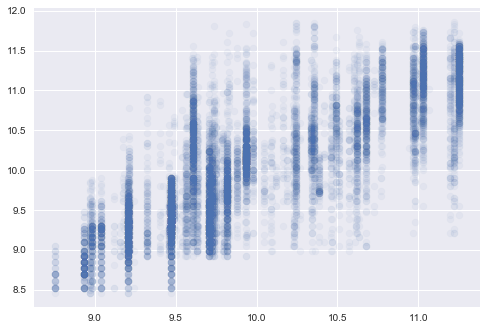

In [64]:
plt.scatter(preds, y_valid, alpha=0.05)

In [65]:
metrics.r2_score(preds,y_valid)

0.4840854669925271

Putting is together

In [69]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [70]:
def fib1(n):
    a,b = 0, 1
    while b < n:
        a,b = b, a+b

In [71]:
%%cython
def fib2(n):
    a,b=0,1
    while b<n:
        a,b = b, a+b

DistutilsPlatformError: Unable to find vcvarsall.bat

In [72]:
%%cython
def fib3(n):
    cdef int b = 1
    cdef int a = 0
    cdef int t = 0
    while b < n:
        t = a
        a = b
        b = b + t
        

DistutilsPlatformError: Unable to find vcvarsall.bat